**LOW LEVEL ANALYSIS**
================================

**Peak Finding**
--------------------
Come prima cosa viene consigliato di guardare questa nota sulla ricerca dei picchi 
[Peakfinding in strax](https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:analysis:strax_clustering_classification) che spiega come funziona in strax la ricostruzione dei segnali dei PMT e l'identificazione in S1 e S2. Qui c'è un riassunto della nota.

Gli step che vengono seguiti sono:

1. Cercare i **peaklets**: regioni di tempo che appartengono allo stesso S1 o S2
2. Calcolare le proprietà di base e classificarli come S1 o S2
3. Unire peaklets parte dello stesso S2

1-HitFinder
-------------
Prima della ricerca dei picchi viene runnato l'**hitfinder**, che deve cercare single-PE e altri **hits**, gli algoritmi utilizzati cercano di ottimizzare l'accettanza dei fotoni. 

2-PeakLets
----------------
Poi gli hits vengono raggruppati nei **peaklets** quando ci sono dei gap >= 350 ns. In questo modo i peaklet possono essere:

*  S1 separati da possibili After Pulses (AP) o altri SE che seguono
*  S2 senza gap
*  Single electrons (un-fragmented)
*  Hits isolati dovuti a dark counts o PMT afterpulses
*  gruppi non risolti a high-energy

3-GoodnessOfSplit
---------------------
Questo non è sufficiente, soprattutto ad alte energie dove possiamo avere APs o PEs. Per i picchi candidati viene calcolata la waveform di somma e viene valutata il **goodness of split**, poi viene separata al massimo se questo supera un certo threshold, quesìoperazione viene ripetuta fino a che on si raggiunge un'area piccola o non si ranggiunge un limite.
Strax ha 2 opzioni per il goodness of split, ma viene usata quella chiamata [**natural breaks**](https://github.com/XENONnT/straxen/pull/45#issuecomment-581973091) che guarda la somma quadratica della deviazione del picco(i) prima e dopo lo split. Il goodness of split threshold può essere funzione dell'area e del risetime dei picchi, in questo modo può anche classificare S1 e S2 (che però viene fatto dopo). [Qui è descritto il threshold usato attualmente](https://github.com/XENONnT/straxen/pull/45#issuecomment-581973091).

4-Classification
--------------------
La classificazione è basata su:
* **Rise time**: tempo per arrivare al 10% dell'area del picco
* **Tight coincidence**: numero di PMT che contribuiscono entro una finestra di 100 ns centrata al massimo della waveform somma

I picchi sono classificati come unknown, S1 o S2 seguendo questo ragionamento:
* picchi con risetime breve (<60ns (<150ns) se l'area è meno (più) di 100 PE) e almeno 3 PMTs sono classificati come S1
* i picchi rimanenti con almeno 4 PMT sono classificato come S2
* altrimenti come unknown

5-Merging
---------------
Il merging serve serve per convertire peaklets in **peaks** ed è applicato nei seguenti casi:
* il merged peak non ha gap tra hits maggiori di 3.5 us
* il primo peaklet è un S2
* l'area del merged peak è minore di 5000 PE
* il tempo del merged peak è minore di 10 us



**Peakfinding: peaklet_processing.py**
---------------------------------------

Ci sono 4 classi nel codice:

*  Peaklets
*  PeakletClassification
*  MergedS2s
*  Peaks

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import straxen
from multihist import Histdd, Hist1d

# Print out exactly what versions we are using, for reference / troubleshooting:
import sys
import os.path as osp

In [2]:
st = straxen.contexts.xenon1t_dali()
run_id = '180215_1029'

Peaklets
---------------
Cerca gli hits e li ordina nel tempo, poi usa il gap threshold per formare dei gruppi di hits.

Poi viene calcolata la waveform somma e la larghezza del picco.

Viene fatto lo split usando i natural breaks.

In [3]:
st.data_info('peaklets')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,type,int8,Classification of the peak(let)
5,area,float32,Integral across channels [PE]
6,area_per_channel,"('<f4', (248,))",Integral per channel [PE]
7,n_hits,int32,Number of hits from which peak was constructed...
8,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
9,width,"('<f4', (11,))",Peak widths in range of central area fraction ...


In [4]:
peaklets = st.get_array(run_id,['peaklets'])
print(peaklets['area'])

[2.6191945 2.4241385 3.2993686 ... 8.369365  2.3876238 1.8463116]


PeakletClassification
------------------------
Classifica come unknown, S1, or S2. Dipende da peaklets

Vengono calcolati rise_time e numeri di PMT come:
* -peaks['area_decile_from_midpoint']
* n_channels = (peaks['area_per_channel'] > 0).sum(axis=1)

se il risetime è minore di 's1_max_rise_time' (o 's1_max_rise_time_post100') e il numeri di canali è almeno 's1_min_coincidence' allora viene classificato come S1

Altrimenti se il numero è almeno 's2_min_pmts' allora è S2.

In [5]:
st.data_info('peaklet_classification')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,type,int8,Classification of the peak(let)


Non viene distinto dove si trovano i PMT che hanno gli hits.

Non c'è una condizione per classificare in base all'area dei picchi.

MergedS2s
-------------------
Serve a fare il merge dei peaklets. Dipende da peaklets e peaklet_classification.

Se la variabile 's2_merge_max_gap' è minore di zero allora non viene fatto il merge (dipende dal gap).

Trova i gruppi di peaklets separati e va il merge usando le impostazioni in 'get_merge_instructions'.

Peaks
---------------
Dipende da peaklets, peaklet_classification e merged_s2s

Rimuove i fake merged S2 e ordina i picchi nel tempo.

**Processamento: pulse_processing.py**
------------------------------------

Nel codice c'è un'unica classe  PulseProcessing. Come prima cosa divide i raw_records in:
* tpc_records
* aqmon_records

Per i TPC records applica il processing di base:
1. inverte, sottrae la baseline e integra la waveform (strax.zero_out_of_bounds, strax.baseline, strax.integrate)

2. applica il software HE veto (software_he_veto)

3. Trova gli hits prima di filtrare (strax.find_hits)

4. applica un filtro lineare per concentrare i PMT pulses: strax.filter_records(r, np.array(self.config['pmt_pulse_filter']))

5. taglia fuori dagli hits (strax.cut_outside_hits)


In [6]:
st.show_config('records')

,option,default,current,applies_to,help
0,hev_gain_model,"(disabled, None)","(to_pe_per_run, https://raw.githubusercontent....","(records, veto_regions, pulse_counts)",PMT gain model used in the software high-energ...
1,baseline_samples,40,<OMITTED>,"(records, veto_regions, pulse_counts)",Number of samples to use at the start of the p...
2,tail_veto_threshold,0,100000,"(records, veto_regions, pulse_counts)",Minimum peakarea in PE to trigger tail veto.Se...
3,tail_veto_duration,3000000,<OMITTED>,"(records, veto_regions, pulse_counts)",Time in ns to veto after large peaks
4,tail_veto_resolution,1000,<OMITTED>,"(records, veto_regions, pulse_counts)",Time resolution in ns for pass-veto waveform s...
5,tail_veto_pass_fraction,0.05,<OMITTED>,"(records, veto_regions, pulse_counts)",Pass veto if maximum amplitude above max * fra...
6,tail_veto_pass_extend,3,<OMITTED>,"(records, veto_regions, pulse_counts)",Extend pass veto by this many samples (tail_ve...
7,pmt_pulse_filter,None,"(0.012, -0.119, 2.435, -1.271, 0.357, -0.174, ...","(records, veto_regions, pulse_counts)","Linear filter to apply to pulses, will be norm..."
8,save_outside_hits,"(3, 20)","(3, 3)","(records, veto_regions, pulse_counts)","Save (left, right) samples besides hits; cut t..."
9,n_tpc_pmts,<OMITTED>,248,"(records, veto_regions, pulse_counts)",Number of TPC PMTs


In [7]:
st.data_info('records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (w...
5,record_i,int16,Fragment number in the pulse
6,area,int32,Integral in ADC counts x samples
7,reduction_level,uint8,Level of data reduction applied (strax.Reducti...
8,baseline,float32,Baseline in ADC counts. data = int(baseline) -...
9,baseline_rms,float32,Baseline RMS in ADC counts. data = baseline - ...


In [9]:
records = st.get_array(run_id,['records'])

110


(450.0, 550.0)

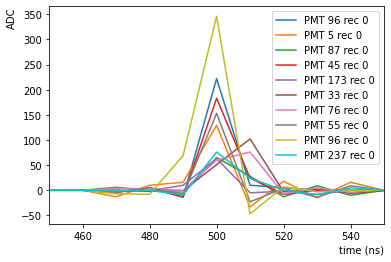

In [43]:
dt = records['dt'][0]
print(records['data'].shape[1])
dts = np.arange(0,records['data'].shape[1]*dt,dt)
for i in range(10):
    plt.plot(dts,records['data'][i],label=f"PMT {records['channel'][i]} rec {records['record_i'][i]}")
plt.legend()
plt.xlabel("time (ns)", ha='right', x=1)
plt.ylabel(f"ADC", ha='right', y=1)
plt.xlim(450,550)

**TUTORIAL**
==========================
Definizioni varie:
* channel
* self-trigger
* pulse 
* record: 
* hit: tempo nel quale il record supera il threshould
* peak: S1 o S2 candidati
* peaklet: candidati di peak
* ADC count
* PE (photoelectron): in XENON 1 PE è l'area media prodotta da un fotone (long-wavelength) che produce un segnale nel PMT

Nello scorso tutorial abbiamo visto tutto quello che è sopra peaks, questa volta si guarda quello che c'è sotto.

Il **DAQ reader** determinare quali chunk salvare e li divide in dati della TPC, del Muon Veto o Neutron Veto.

Il **Pulse Processing**, calcola la baseline, cerca gli hits e taglia al di fuori di questi, fa il filtraggio e applica il software HEV?

Dopo con il **Peaklet Processing** si cercano e classificano i peaklet per creare i peaks.

Esempio: processamento di run
---------------------------------
raw_records: 83 GB raw, 25 GB on disk
Prende più tempo per fare il pulse processing (50%), in particolare il **filtering** (a causa delle convoluzioni). Le operazioni con i peaklets occupano circa il 17% del tempo, mentre le analisi di alto livello sono molto più veloci.

In strax i records sono salvati con la stessa lunghezza, se necessario vengono frammentati, questo per evitare oggetti di diversa lunghezza.